In [1]:
import csv
import pandas as pd
import numpy as np
from datetime import datetime
import random

from sklearn.model_selection import train_test_split

In [2]:
filename = 'dataset_training.csv'

file = open(filename)
csvreader = csv.reader(file)

In [3]:
# fields extracted
header = []
header = next(csvreader)
header

['No.',
 'DateTime',
 'Time',
 'Source',
 'Destination',
 'Protocol',
 'Length',
 'Delta Time',
 'Arrival Time']

In [4]:
data= pd.read_csv(filename, encoding = "ISO-8859-1")

resampling_frequency='1000ms'
time=1000
test_size=0.4

#filter rows by column values
data = data [data['Protocol']=='RTP']
#select multiple columns
data = pd.DataFrame(data, columns=['No.','Source', 'Destination','Time', 'DateTime','Length', 'Delta Time'])

# Dataset Preparation

In [5]:
# add ground truth column
label = [None] * data['Length'].count()
data.insert(len(data.columns), "Inbound", label ,True)

for index,row in data.iterrows():
    if(row['Destination']=='10.0.2.15'):
     data.at[index,'Inbound']=1
    else:
      data.at[index,'Inbound']=0

In [6]:
# convert DateTime from string to index to be used for resampling

from pandas.core.indexes.datetimes import DatetimeIndex
data['DateTime'] = pd.to_datetime(data['DateTime'], format='%H:%M:%S.%f')
data_index = pd.DatetimeIndex(data['DateTime'])
data = data.set_index(data_index)

In [7]:
inbound = data[data['Destination']=='10.0.2.15']
outbound = data[data['Source']=='10.0.2.15']

# AGGREGATE
# number of packets after resampling
data_counter = data.groupby([pd.Grouper(key='DateTime', freq=resampling_frequency)]).count()
# compute average of the aggregate's features
data = data.groupby([pd.Grouper(key='DateTime', freq=resampling_frequency)]).mean().groupby(level=0).mean()

# INBOUND
# number of packets after resampling
inbound_counter = inbound.groupby([pd.Grouper(key='DateTime', freq=resampling_frequency)]).count()
# compute average of the aggregate's features
inbound = inbound.groupby([pd.Grouper(key='DateTime', freq=resampling_frequency)]).mean().groupby(level=0).mean()

# OUTBOUND
# number of packets after resampling
outbound_counter = outbound.groupby([pd.Grouper(key='DateTime', freq=resampling_frequency)]).count()
# compute average of the aggregate's features
outbound = outbound.groupby([pd.Grouper(key='DateTime', freq=resampling_frequency)]).mean().groupby(level=0).mean()


inbound= inbound.loc[:, inbound.columns != 'No.']
outbound= outbound.loc[:, outbound.columns != 'No.']

inbound = inbound.rename(columns={'Time': 'Time (Inbound)', 'Length':'Length (Inbound)', 'Delta Time': 'Delta Time (Inbound)'})
outbound = outbound.rename(columns={'Time': 'Time (Outbound)', 'Length':'Length (Outbound)', 'Delta Time': 'Delta Time (Outbound)'})

inbound.insert(0, "Number of packets (Inbound)", inbound_counter['No.'].values,True)
outbound.insert(0, "Number of packets (Outbound)", outbound_counter['No.'].values,True)

In [8]:
# AGGREGATE
# add number of packets column
data.insert(0, "Number of packets", data_counter['No.'].values,True)
data.drop('No.', axis=1, inplace=True)

# add average length per ms
bytes_per_ms = data['Length']/time
data.insert(len(data.columns), "Bytes/ms", bytes_per_ms, True)

# add bit-rate column
rate = data['Number of packets']/time
data.insert(len(data.columns), "Bit-Rate", rate, True)


# INBOUND
# add average length per ms
bytes_per_ms = inbound['Length (Inbound)']/time
inbound.insert(len(inbound.columns), "Bytes/ms (Inbound)", bytes_per_ms, True)

# add bit-rate column
rate = inbound['Number of packets (Inbound)']/time
inbound.insert(len(inbound.columns), "Bit-Rate (Inbound)", rate, True)

inbound.drop('Time (Inbound)', axis=1, inplace=True)
inbound.drop('Number of packets (Inbound)', axis=1, inplace=True)

# OUTBOUND
# add average length per ms
bytes_per_ms = outbound['Length (Outbound)']/time
outbound.insert(len(outbound.columns), "Bytes/ms (Outbound)", bytes_per_ms, True)

# add bit-rate column
rate = outbound['Number of packets (Outbound)']/time
outbound.insert(len(outbound.columns), "Bit-Rate (Outbound)", rate, True)

outbound.drop('Time (Outbound)', axis=1, inplace=True)
outbound.drop('Number of packets (Outbound)', axis=1, inplace=True)

In [9]:
overall = pd.concat([inbound, outbound], axis=1)
overall = pd.concat([data,overall], axis=1)

In [10]:
data = overall

# fill ground truth values

for index,row in data.iterrows():
    if(row['Time']<120):
     data.at[index,'Person']=1
    else:
      data.at[index,'Person']=0
data.drop('Time', axis=1, inplace=True)
data.drop('Number of packets', axis=1, inplace=True)
data

,Length,Delta Time,Bytes/ms,Bit-Rate,Length (Inbound),Delta Time (Inbound),Bytes/ms (Inbound),Bit-Rate (Inbound),Length (Outbound),Delta Time (Outbound),Bytes/ms (Outbound),Bit-Rate (Outbound),Person
DateTime,,,,,,,,,,,,,
1900-01-01 11:53:01,866.200000,0.003475,0.866200,0.070,1022.206897,0.002684,1.022207,0.058,112.166667,0.007301,0.112167,0.012,1.0
1900-01-01 11:53:02,944.723404,0.003036,0.944723,0.188,968.038251,0.003014,0.968038,0.183,91.400000,0.003825,0.091400,0.005,1.0
1900-01-01 11:53:03,972.168539,0.003106,0.972169,0.178,992.344828,0.002937,0.992345,0.174,94.500000,0.010468,0.094500,0.004,1.0
1900-01-01 11:53:04,917.197970,0.003668,0.917198,0.197,943.041885,0.003429,0.943042,0.191,94.500000,0.011282,0.094500,0.006,1.0
1900-01-01 11:53:05,872.033493,0.003663,0.872033,0.209,898.698020,0.003318,0.898698,0.202,102.571429,0.013620,0.102571,0.007,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1900-01-01 11:56:57,446.227848,0.005112,0.446228,0.158,521.255814,0.005064,0.521256,0.129,112.482759,0.005327,0.112483,0.029,0.0
1900-01-01 11:56:58,430.455090,0.004563,0.430455,0.167,509.000000,0.004344,0.509000,0.134,111.515152,0.005453,0.111515,0.033,0.0
1900-01-01 11:56:59,502.571429,0.005822,0.502571,0.140,514.573529,0.005875,0.514574,0.136,94.500000,0.004031,0.094500,0.004,0.0


Dataset Cleaning

In [11]:
# function to eliminate NaN and infinite values

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [ ]:
# Ground-Truth training dataset
pd.DataFrame(data['Person']).to_csv("ground_truth.csv")

In [13]:
clean_dataset(data)

X = data.loc[:, data.columns != 'Person']
X = X.values
y = data['Person']
y=y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=test_size, random_state=0)

# Models Fitting

Naive Bayes

In [14]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB().fit(X_train, y_train)

print("score on test: " + str(mnb.score(X_test, y_test)))
print("score on train: "+ str(mnb.score(X_train, y_train)))

score on test: 0.5416666666666666
score on train: 0.5833333333333334


Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(X_train, y_train)

print("score on train: "+ str(lr.score(X_train, y_train)))
print("score on test: " + str(lr.score(X_test, y_test)))

score on train: 0.8541666666666666
score on test: 0.8333333333333334


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


K-Nearest Neighbor

In [16]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)
knn.fit(X_train, y_train)

print("train shape: " + str(X_train.shape))
print("score on test: " + str(knn.score(X_test, y_test)))
print("score on train: "+ str(knn.score(X_train, y_train)))

train shape: (144, 12)
score on test: 0.75
score on train: 0.8888888888888888


Decision Tree

In [17]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

print("score on test: "  + str(dt.score(X_test, y_test)))
print("score on train: " + str(dt.score(X_train, y_train)))

# BEST RESULT :
# freq: 1s, test_size: 0.4

score on test: 0.8645833333333334
score on train: 1.0


Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=30, max_depth=9)
rf.fit(X_train, y_train)

print("score on test: " + str(rf.score(X_test, y_test)))
print("score on train: "+ str(rf.score(X_train, y_train)))

# BEST RESULT:
# freq: 500ms, test_size:0.35

score on test: 0.8541666666666666
score on train: 1.0


Bagging Decision Tree

In [19]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
# max_samples: maximum size 0.5=50% of each sample taken from the full dataset
# max_features: maximum of features 1=100% taken here all 10K 
# n_estimators: number of decision trees 
bg=BaggingClassifier(DecisionTreeClassifier(),max_samples=0.5,max_features=1.0,n_estimators=10)
bg.fit(X_train, y_train)
print("score on test: " + str(bg.score(X_test, y_test)))
print("score on train: "+ str(bg.score(X_train, y_train)))

# BEST RESULT:
# freq: 1000ms, test_size:0.25

score on test: 0.8645833333333334
score on train: 0.9722222222222222


Boosting Decision Tree

In [20]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
adb = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=4),n_estimators=10,learning_rate=0.6)
adb.fit(X_train, y_train)

print("score on test: " + str(adb.score(X_test, y_test)))
print("score on train: "+ str(adb.score(X_train, y_train)))

# BEST RESULT:
# freq: 1000ms, test_size:0.25

score on test: 0.8854166666666666
score on train: 1.0


Voting Classifier

In [21]:
from sklearn.ensemble import VotingClassifier

evc=VotingClassifier(estimators=[('dt',dt),('adb',adb),('rf',rf),('knn',knn)],voting='hard')
evc.fit(X_train, y_train)
print("score on test: " + str(evc.score(X_test, y_test)))
print("score on train: "+ str(evc.score(X_train, y_train)))

# BEST RESULT:
# freq: 1000ms, test_size:0.25

score on test: 0.8541666666666666
score on train: 1.0


Neural Network

In [22]:
#!pip install scikeras

In [23]:
from keras import layers
from keras import models
from keras import optimizers
from keras import losses
from keras import regularizers
from keras import metrics
import tensorflow as tf


# add validation dataset
validation_split=100

x_validation=X_train[:validation_split]
x_partial_train=X_train[validation_split:]
y_validation=y_train[:validation_split]
y_partial_train=y_train[validation_split:]

model=models.Sequential()
model.add(layers.Dense(512,kernel_regularizer=regularizers.l2(0.003),activation='tanh',input_shape=(12,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256,kernel_regularizer=regularizers.l2(0.003),activation='tanh'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(64,kernel_regularizer=regularizers.l2(0.003),activation='leaky_relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1,activation='sigmoid'))

sgd = tf.keras.optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd,loss='binary_crossentropy',metrics=['accuracy'])
#model.fit(x_partial_train,y_partial_train,epochs=200,batch_size=128,validation_data=(x_validation,y_validation))

print("score on test: " + str(model.evaluate(X_test,y_test)[1]))
print("score on train: "+ str(model.evaluate(X_train,y_train)[1]))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


3/3 [==============================] - 1s 5ms/step - loss: 2.1653 - accuracy: 0.5208
score on test: 0.5208333134651184
5/5 [==============================] - 0s 4ms/step - loss: 2.1979 - accuracy: 0.4931
score on train: 0.4930555522441864


# Prediction

In [24]:
filename = 'prediction_capture.csv'
file = open(filename)
csvreader = csv.reader(file)
prediction = pd.read_csv(filename, encoding = "ISO-8859-1")

#filter rows by column values
prediction = prediction [prediction['Protocol']=='RTP']
#select multiple columns
prediction = pd.DataFrame(prediction, columns=['No.','Time','Source', 'Destination','DateTime','Length', 'Delta Time'])

# add ground truth column
label = [None] * prediction['Length'].count()
prediction.insert(len(prediction.columns), "Inbound", label ,True)

for index,row in prediction.iterrows():
    if(row['Destination']=='192.168.1.219'):
     prediction.at[index,'Inbound']=1
    else:
      prediction.at[index,'Inbound']=0

# convert DateTime from string to index to be used for resampling
from pandas.core.indexes.datetimes import DatetimeIndex
prediction['DateTime'] = pd.to_datetime(prediction['DateTime'], format='%H:%M:%S.%f')
prediction_index = pd.DatetimeIndex(prediction['DateTime'])
prediction = prediction.set_index(prediction_index)

prediction_inbound = prediction[prediction['Destination']=='192.168.1.219']
prediction_outbound = prediction[prediction['Source']=='192.168.1.219']

# AGGREGATE
# number of packets after resampling
prediction_counter = prediction.groupby([pd.Grouper(key='DateTime', freq=resampling_frequency)]).count()
# compute average of the aggregate's features
prediction = prediction.groupby([pd.Grouper(key='DateTime', freq=resampling_frequency)]).mean().groupby(level=0).mean()

# INBOUND
# number of packets after resampling
prediction_inbound_counter = prediction_inbound.groupby([pd.Grouper(key='DateTime', freq=resampling_frequency)]).count()
# compute average of the aggregate's features
prediction_inbound = prediction_inbound.groupby([pd.Grouper(key='DateTime', freq=resampling_frequency)]).mean().groupby(level=0).mean()

# OUTBOUND
# number of packets after resampling
prediction_outbound_counter = prediction_outbound.groupby([pd.Grouper(key='DateTime', freq=resampling_frequency)]).count()
# compute average of the aggregate's features
prediction_outbound = prediction_outbound.groupby([pd.Grouper(key='DateTime', freq=resampling_frequency)]).mean().groupby(level=0).mean()


prediction_inbound= prediction_inbound.loc[:, prediction_inbound.columns != 'No.']
prediction_outbound= prediction_outbound.loc[:, prediction_outbound.columns != 'No.']

prediction_inbound = prediction_inbound.rename(columns={'Time': 'Time (Inbound)', 'Length':'Length (Inbound)', 'Delta Time': 'Delta Time (Inbound)'})
prediction_outbound = prediction_outbound.rename(columns={'Time': 'Time (Outbound)', 'Length':'Length (Outbound)', 'Delta Time': 'Delta Time (Outbound)'})

prediction_inbound.insert(0, "Number of packets (Inbound)", prediction_inbound_counter['No.'].values,True)
prediction_outbound.insert(0, "Number of packets (Outbound)", prediction_outbound_counter['No.'].values,True)


# AGGREGATE
# add number of packets column
prediction.insert(0, "Number of packets", prediction_counter['No.'].values,True)
prediction.drop('No.', axis=1, inplace=True)

# add average length per ms
bytes_per_ms = prediction['Length']/time
prediction.insert(len(prediction.columns), "Bytes/ms", bytes_per_ms, True)

# add bit-rate column
rate = prediction['Number of packets']/time
prediction.insert(len(prediction.columns), "Bit-Rate", rate, True)


# INBOUND
# add average length per ms
bytes_per_ms = prediction_inbound['Length (Inbound)']/time
prediction_inbound.insert(len(prediction_inbound.columns), "Bytes/ms (Inbound)", bytes_per_ms, True)

# add bit-rate column
rate = prediction_inbound['Number of packets (Inbound)']/time
prediction_inbound.insert(len(prediction_inbound.columns), "Bit-Rate (Inbound)", rate, True)

prediction_inbound.drop('Time (Inbound)', axis=1, inplace=True)

# OUTBOUND
# add average length per ms
bytes_per_ms = prediction_outbound['Length (Outbound)']/time
prediction_outbound.insert(len(prediction_outbound.columns), "Bytes/ms (Outbound)", bytes_per_ms, True)

# add bit-rate column
rate = prediction_outbound['Number of packets (Outbound)']/time
prediction_outbound.insert(len(prediction_outbound.columns), "Bit-Rate (Outbound)", rate, True)

prediction_outbound.drop('Time (Outbound)', axis=1, inplace=True)

overall = pd.concat([prediction_inbound, prediction_outbound], axis=1)
prediction = pd.concat([prediction,overall], axis=1)

In [25]:
clean_dataset(prediction)
# add ground truth column
label = [None] * prediction['Length'].count()
prediction.insert(len(prediction.columns), "Person", label ,True)

for index,row in prediction.iterrows():
    if(row['Time']<60 or (row['Time']>=120 and row['Time']<180)):
     prediction.at[index,'Person']=1
    else:
      prediction.at[index,'Person']=0

timestamps = prediction['Time']
prediction.drop('Time', axis=1, inplace=True)

prediction.drop('Number of packets', axis=1, inplace=True)
prediction.drop('Number of packets (Inbound)', axis=1, inplace=True)
prediction.drop('Number of packets (Outbound)', axis=1, inplace=True)


prediction

,Length,Delta Time,Bytes/ms,Bit-Rate,Length (Inbound),Delta Time (Inbound),Bytes/ms (Inbound),Bit-Rate (Inbound),Length (Outbound),Delta Time (Outbound),Bytes/ms (Outbound),Bit-Rate (Outbound),Person
DateTime,,,,,,,,,,,,,
1900-01-01 13:37:17,836.189427,0.002055,0.836189,0.227,901.223077,0.000515,0.901223,0.130,749.030928,0.004118,0.749031,0.097,1
1900-01-01 13:37:18,725.228739,0.002183,0.725229,0.341,688.132979,0.001117,0.688133,0.188,770.810458,0.003493,0.770810,0.153,1
1900-01-01 13:37:19,767.161512,0.002344,0.767162,0.291,777.886525,0.001111,0.777887,0.141,757.080000,0.003504,0.757080,0.150,1
1900-01-01 13:37:20,820.416149,0.002171,0.820416,0.322,850.238372,0.000800,0.850238,0.172,786.220000,0.003742,0.786220,0.150,1
1900-01-01 13:37:21,785.569182,0.002229,0.785569,0.318,808.783951,0.000777,0.808784,0.162,761.461538,0.003736,0.761462,0.156,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1900-01-01 13:41:13,501.236364,0.002733,0.501236,0.275,602.391753,0.000967,0.602392,0.194,258.962963,0.006964,0.258963,0.081,0
1900-01-01 13:41:14,429.505415,0.002828,0.429505,0.277,437.481283,0.000945,0.437481,0.187,412.933333,0.006738,0.412933,0.090,0
1900-01-01 13:41:15,491.483221,0.002631,0.491483,0.298,458.584211,0.000822,0.458584,0.190,549.361111,0.005813,0.549361,0.108,0


In [26]:
# creation of the prediction label to be plotted

#prediction_label = lr.predict(prediction.loc[:, prediction.columns !='Person'])
#prediction_label = mnb.predict(prediction.loc[:, prediction.columns !='Person'])
#prediction_label = knn.predict(prediction.loc[:, prediction.columns !='Person'])
#prediction_label = svm.predict(prediction.loc[:, prediction.columns !='Person'])
prediction_label = dt.predict(prediction.loc[:, prediction.columns !='Person'])
#prediction_label = rf.predict(prediction.loc[:, prediction.columns !='Person'])
#prediction_label = bg.predict(prediction.loc[:, prediction.columns !='Person'])
#prediction_label = adb.predict(prediction.loc[:, prediction.columns !='Person'])
#prediction_label = evc.predict(prediction.loc[:, prediction.columns !='Person'])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


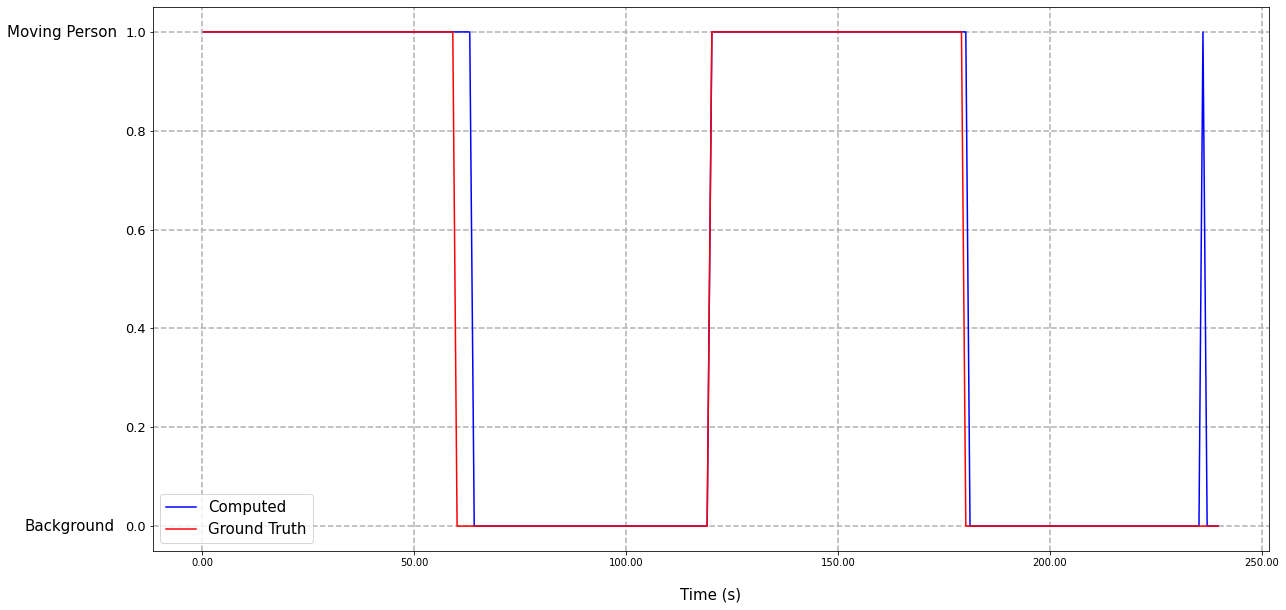

In [27]:
import matplotlib.pyplot as plot
from matplotlib.ticker import StrMethodFormatter

values = timestamps

plot.figure(figsize=(20,10))
plot.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
plot.plot(   
    values,   
      prediction_label,
     color = 'blue')
plot.plot(
    values,
     prediction['Person'],
    color ='red',
)
plot.legend(["Computed", "Ground Truth"], fontsize=15)
plot.yticks(fontsize=13)

plot.annotate('Moving Person', xy=(1, 1), xytext=(-46,0.99), fontsize=15)
plot.annotate('Background', xy=(1, 1), xytext=(-42,-0.01), fontsize=15)
plot.xlabel('Time (s)', fontsize=15, labelpad=20)
plot.grid(linestyle='--', linewidth=1.5)
plot.show()

CSV Export

In [28]:
pd.DataFrame(prediction_label).to_csv("prediction_label.csv")

pd.DataFrame(prediction['Person']).to_csv("ground_truth_label.csv")

pd.DataFrame(values).to_csv("timestamps.csv")

# Confusion Matrix

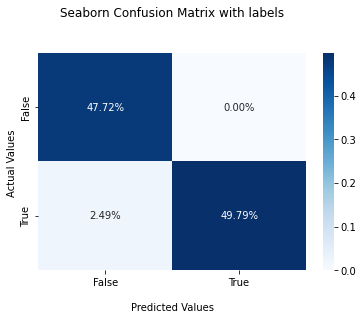

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(prediction_label.astype(float), prediction['Person'].astype(float))

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
fmt='.2%', cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plot.show()

# Learning Rate

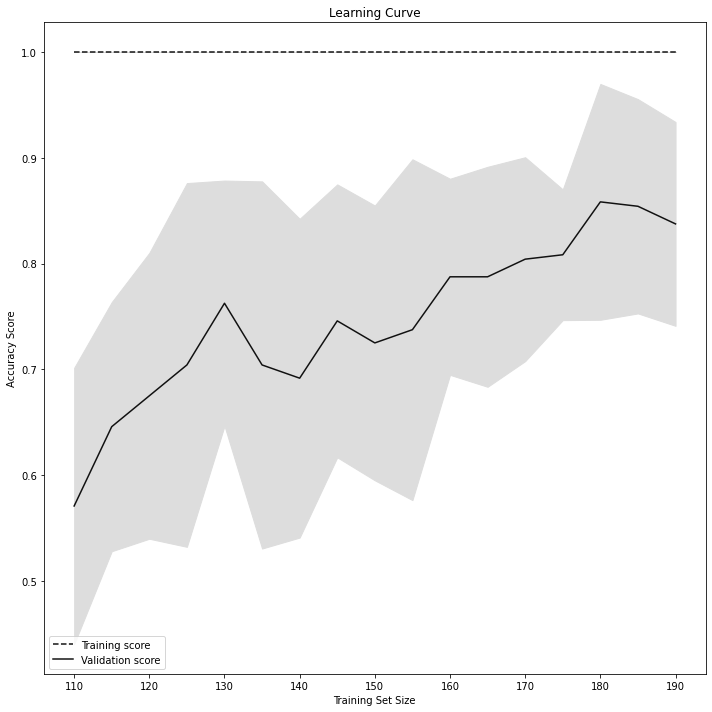

In [30]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import sklearn
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

# to check the others you must change the estimator field (with the same parameters of the fitting section)
train_sizes, train_scores, validation_scores = learning_curve(
estimator = DecisionTreeClassifier(),
X = X, y = y, train_sizes = np.arange(110, 192, 5), cv = 5)

train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)

plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_scores_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, validation_scores_mean, color="#111111", label="Validation score")

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(validation_scores, axis=1)
test_std = np.std(validation_scores, axis=1)

plt.fill_between(train_sizes, train_scores_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, validation_scores_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()